# Neural Network Framework Example
### Todo
* L2 loss
* RMSProp
* batch norm

### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.datasets
import utils
import time
import math

import nn_framework.framework as nn

%load_ext autoreload
%autoreload 2
%matplotlib inline

point_size = 5
cmap = plt.cm.Spectral

### Load and visualize dataset

X.shape = (2, 3000), Y.shape = (1, 3000)


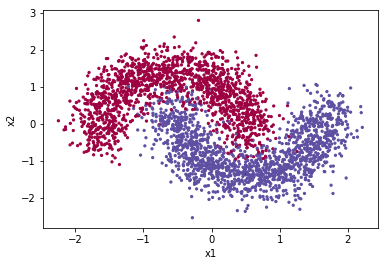

In [2]:
m = 3000
X, Y = sklearn.datasets.make_moons(n_samples=m, noise=0.2)
# X, Y = sklearn.datasets.make_gaussian_quantiles(n_samples=m, n_classes=2)
X = X.T
Y = Y.reshape(-1, 1).T
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

assert X.shape[0] == 2 and Y.shape[0] == 1
print('X.shape = %s, Y.shape = %s' % (X.shape, Y.shape))
plt.scatter(X[0, :], X[1, :], c=Y, cmap=cmap, s=point_size)
plt.ylabel('x2')
plt.xlabel('x1')

### Comparing gradients with tensorflow

In [3]:
def compare(a, b):
  return np.linalg.norm(a - b) / (np.linalg.norm(a) + np.linalg.norm(b))

tf.reset_default_graph()
m = 1000
n = 20
n_h = 50

w = np.random.randn(n_h, n)
b = np.random.randn(n_h, 1)
t1 = np.random.randn(n, n_h)
t2 = np.random.randn(n, m)

# TensorFlow
wtf = tf.constant(w)
biastf = tf.constant(b)
atf = wtf * 2
atf *= atf
btf = (tf.matmul(t1, tf.matmul(wtf, t2)) + 1) * 2 - 3
btf *= btf

ztf = tf.matmul(atf, btf) + biastf ** 2
ztf *= ztf
[dwtf, dbtf] = tf.gradients(ztf, [wtf, biastf])

# NN framework
wmy = nn.variable(w)
biasmy = nn.variable(b)
amy = wmy * 2
amy *= amy
bmy = (nn.const(t1) @ wmy @ t2 + 1) * 2 - 3
bmy *= bmy

zmy = amy @ bmy + biasmy ** 2
zmy *= zmy
dwmy, dbmy = zmy.deriv(wmy, nn.ones(zmy.shape)), zmy.deriv(biasmy, nn.ones(zmy.shape))

with tf.Session() as sess:
  [dwtf_val, dbtf_val] = sess.run([dwtf, dbtf])
  [dwmy_val, dbmy_val] = nn.Session().run([dwmy, dbmy], {})
  
  assert dwtf_val.shape == dwmy_val.shape, 'dw shapes should match'
  assert dbtf_val.shape == dbmy_val.shape, 'db shapes should match'
  
  dw_mse = compare(dwtf_val, dwmy_val)
  db_mse = compare(dbtf_val, dbmy_val)
  
  print('actual test: dw mse: %s, db mse: %s' % (dw_mse, db_mse))

actual test: dw mse: 2.22155159795e-16, db mse: 2.31950586403e-16


### Build a graph

In [4]:
def dense(X, input_dim, output_dim):
  W = nn.variable(np.random.randn(output_dim, input_dim) * (1 / math.sqrt(input_dim)))
  b = nn.variable(np.ones([output_dim, 1]))
  return W @ X + b

n_hid = 16
learning_rate = 0.01

global_step = nn.variable(0)
keep_prob = nn.placeholder('keep_prob', [])
A0 = nn.placeholder('X', [X.shape[0], None])
labels = nn.placeholder('Y', [Y.shape[0], None])
net = A0

net = dense(net, input_dim=2, output_dim=n_hid)
net = nn.relu(net)
net = nn.dropout(net, keep_prob=keep_prob)

net = dense(net, input_dim=n_hid, output_dim=n_hid)
net = nn.relu(net)
net = nn.dropout(net, keep_prob=keep_prob)

net = dense(net, input_dim=n_hid, output_dim=n_hid)
net = nn.relu(net)
net = nn.dropout(net, keep_prob=keep_prob)

net = dense(net, input_dim=n_hid, output_dim=1)  

# net = nn.sigmoid(net)
# Y_hat = net
# loss = nn.mean(nn.logistic_logistic_loss(a=Y_hat, y=labels)) # numerically unstable
logits = net
Y_hat = nn.sigmoid(net)
loss = nn.mean(nn.sigmoid_logistic_loss(logits=logits, labels=labels))
accuracy = nn.mean(nn.eq((Y_hat > 0.5), labels)) * 100

# train = nn.GradientDescentOptimizer(loss, learning_rate, global_step)
# train = nn.MomentumOptimizer(loss, learning_rate, global_step)
train = nn.AdamOptimizer(loss, learning_rate, global_step)

nn.gradient_check(loss, {A0: X, labels: Y, keep_prob: 1.0})

gradient check: 6.05683596915e-08


6.0568359691513022e-08

### Train

step: 0, loss: 1.170409, accuracy: 34.7333333333
step: 200, loss: 0.277214, accuracy: 88.3666666667
step: 400, loss: 0.125809, accuracy: 96.1
step: 600, loss: 0.099603, accuracy: 96.4
step: 800, loss: 0.097786, accuracy: 96.6666666667
step: 1000, loss: 0.104348, accuracy: 96.4333333333
step: 1200, loss: 0.105694, accuracy: 96.4
step: 1400, loss: 0.101670, accuracy: 96.5
step: 1600, loss: 0.097056, accuracy: 96.7666666667
step: 1800, loss: 0.100551, accuracy: 96.4333333333
step: 2000, loss: 0.099776, accuracy: 96.7333333333
step: 2200, loss: 0.096910, accuracy: 96.6333333333
step: 2400, loss: 0.104625, accuracy: 96.6333333333
step: 2600, loss: 0.094144, accuracy: 96.5
step: 2800, loss: 0.095761, accuracy: 96.7


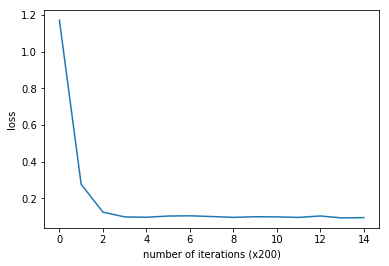

In [5]:
batch_size = 64
steps = 3000
log_interval = 200
kp = 0.8

losses = []
batches = math.floor(m / batch_size)
sess = nn.Session()

try:
  for i in range(0, steps):
    batch = i % batches
    X_batch, Y_batch = X[:, batch * batch_size:(batch + 1) * batch_size], Y[:, batch * batch_size:(batch + 1) * batch_size]
    sess.run([train], {A0: X_batch, labels: Y_batch, keep_prob: kp})

    if i % log_interval == 0:
      [l, acc] = sess.run([loss, accuracy], {A0: X, labels: Y, keep_prob: 1.0})
      print('step: %d, loss: %f, accuracy: %s' % (i, l, acc))
      losses.append(l)
finally:
  plt.plot(losses)
  plt.xlabel('number of iterations (x%s)' % log_interval)
  plt.ylabel('loss')
  
# nn.gradient_check(loss, {A0: X, labels: Y, keep_prob: 1.0})

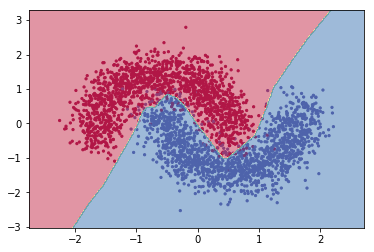

In [6]:
utils.plot_decision_boundary(lambda x: sess.run([Y_hat], {A0: x.T, keep_prob: 1.0})[0] > 0.5, X, Y, cmap=cmap, s=point_size)